In [1]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = datasets.fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = None)
test_dataset = datasets.fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = None)

In [3]:
from nltk import WordNetLemmatizer
from nltk import pos_tag
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
#Define Stopwords, here we use stopwords in text package
stop_words=text.ENGLISH_STOP_WORDS
print("number of stop_words in sklearn text:%s" % len(stop_words))

number of stop_words in sklearn text:318


In [4]:
#Lemmatization
lemmatizer=WordNetLemmatizer()
#Define lemmatizer pos_tag to deal with adj, verb, noun and adv separately
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#Preprocessing: exclude some symbols and numbers in each sentence
exclude_sign="~#$%^&*(){}[]<>|+=1234567890"
replace_sign="@,.?!-;"
def preprocessing(data):
    processed_sentence=[]
    for i in range(len(data)):
        sentence=data[i]
        for c in exclude_sign:
            sentence=sentence.replace(c,"")
        for c in replace_sign:
            sentence=sentence.replace(c," ")
        processed_token=[lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]
        processed_sentence.append(" ".join(processed_token))
    return processed_sentence
#Training

vectorizer=CountVectorizer(stop_words='english',min_df=3)

In [5]:
#implement new dataset
categories_computer=['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
categories_rec=['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
computer_train=datasets.fetch_20newsgroups(subset = 'train', categories = categories_computer, shuffle = True, random_state = None).data
computer_test=datasets.fetch_20newsgroups(subset = 'test', categories = categories_computer, shuffle = True, random_state = None).data
recreation_train=datasets.fetch_20newsgroups(subset = 'train', categories = categories_rec, shuffle = True, random_state = None).data
recreation_test=datasets.fetch_20newsgroups(subset = 'test', categories = categories_rec, shuffle = True, random_state = None).data

In [6]:
#implement new dataset cont'd: combine train and test together and save as X_overall
X_train=computer_train+recreation_train
X_test=computer_test+recreation_test
X_overall=X_train+X_test
Y_train=[1]*len(computer_train)+[0]*len(recreation_train)
Y_test=[1]*len(computer_test)+[0]*len(recreation_test)
print(np.shape(X_overall))

(7882,)


In [7]:
#Lemmatization
processed_train_data=preprocessing(X_overall)




In [9]:
#Vectorization
data_vec=vectorizer.fit_transform(processed_train_data)




In [10]:
#TdIdf
from sklearn.feature_extraction.text import TfidfTransformer
TdT=TfidfTransformer()
data_vec_ti=TdT.fit_transform(data_vec)




In [11]:
#LSI
from sklearn.decomposition import TruncatedSVD
transformer=TruncatedSVD(n_components=50)
data_svd=transformer.fit_transform(data_vec_ti)
print(np.shape(data_svd))




(7882, 50)


In [12]:
#nmf
from sklearn.decomposition import NMF
nmf=NMF(n_components=50)
data_nmf=nmf.fit_transform(data_vec_ti)
print(np.shape(data_nmf))
print(type(data_svd))

(7882, 50)
<type 'numpy.ndarray'>


In [13]:
#error
xhat=np.dot(data_svd,transformer.components_)

data_mat=data_vec_ti.todense()
data_ar=data_mat.getA()

dif=xhat-data_mat
error=0
print(type(dif))
print(np.shape(dif))
error_lsi=np.sqrt(np.trace(np.dot(dif.T,dif)))
print('LSI error:')
print(error_lsi)

nmf_div=nmf.reconstruction_err_
print('NMF error:')
print(nmf_div)

<class 'numpy.matrix'>
(7882, 21423)
LSI error:
83.3838947603005
NMF error:
83.68714377746208


In [14]:
X_train_tf=data_svd[0:len(X_train)]
print(np.shape(X_train_tf))
X_test_tf=data_svd[len(X_train):]
print(np.shape(X_test_tf))

(4732, 50)
(3150, 50)


# Questioni 6
Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

def naive_Gaussian_model(X_train, Y_train, X_test, Y_test):
    Gaussian_classifier=GaussianNB()
    Gaussian_classifier.fit(X_train, Y_train)
    predict_target=Gaussian_classifier.predict(X_test)
    #print('predict_score from decision function is')
    #print(predict_score)
    #print('predict_score_1 from predict_proba is ')
    predict_score_1=Gaussian_classifier.predict_proba(X_test)  
    FPR, TPR, threshold=metrics.roc_curve(Y_test,predict_score_1[:,1])
    return (predict_target, predict_score_1, FPR, TPR, threshold)

In [20]:
#Evalutation

#Model Metrics
def evaluation(Y_predict, Y_test, FPR, TPR):
    confusion_matrix=metrics.confusion_matrix(Y_test,Y_predict)
    accuracy=metrics.accuracy_score(Y_test, Y_predict)
    recall=metrics.recall_score(Y_test, Y_predict, average='binary')
    precision=metrics.precision_score(Y_test, Y_predict, average='binary')
    f1_score=metrics.f1_score(Y_test, Y_predict, average='binary')
    roc=metrics.auc(FPR, TPR)
    plt.plot(FPR,TPR, lw=2, label='area under vurve= %0.4f' % roc)
    plt.show()
    print('Confusion matrix is: ')
    print(confusion_matrix)
    print('accuracy: %f' % accuracy)
    print('recall: %f' % recall)
    print('precision: %f' % precision)
    print('f1_score: %f' % f1_score)

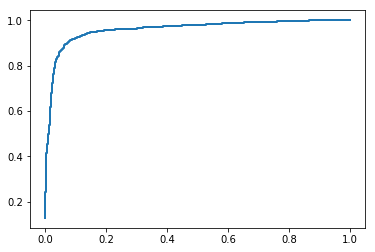

Confusion matrix is: 
[[1487  103]
 [ 160 1400]]
accuracy: 0.916508
recall: 0.897436
precision: 0.931470
f1_score: 0.914136


In [25]:
predict_target, predict_score, FPR, TPR, threshold= naive_Gaussian_model(X_train_tf, Y_train, X_test_tf, Y_test)
evaluation(predict_target, Y_test, FPR, TPR)